<a href="https://colab.research.google.com/github/sjbriggsdev/cd_finalproject/blob/master/Final_Project_Predict_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Predict Heart Disease
- Steven Briggs
- 03/25/22

## DATA CLEANING AND PREP

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
df=pd.read_csv('/content/drive/MyDrive/DATA/chddata.csv')
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [4]:
# using this command to compare to Data Dictionary dtypes.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


---

First attempt to convert Na_to_K Column failed because of a string so I replaced that string with a number and tried again.

---

In [5]:
# Checking for null values shows Age and BP Columns with missing
df.isna().sum()

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

In [6]:
# Checking for duplicated rows, found none.
df[df.duplicated()]

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd


---

The function below looks for unique values in each column

---

In [7]:
for col in df:
  isunique = df[col].unique()
  isunique.sort()
  print(f'- {col}:')
  print(isunique)

- sbp:
[101 102 103 106 108 109 110 112 114 116 117 118 120 121 122 123 124 126
 127 128 129 130 132 134 136 137 138 140 142 143 144 145 146 148 150 152
 153 154 156 158 160 161 162 164 166 168 170 174 176 178 180 182 188 190
 194 198 200 206 208 214 216 218]
- tobacco:
[0.000e+00 1.000e-02 2.000e-02 3.000e-02 4.000e-02 5.000e-02 6.000e-02
 7.000e-02 8.000e-02 9.000e-02 1.000e-01 1.200e-01 1.600e-01 1.800e-01
 2.100e-01 2.800e-01 3.000e-01 3.100e-01 4.000e-01 4.100e-01 4.200e-01
 4.500e-01 4.600e-01 4.800e-01 5.000e-01 5.200e-01 5.400e-01 5.600e-01
 5.700e-01 6.000e-01 6.100e-01 6.400e-01 7.000e-01 7.200e-01 7.300e-01
 7.500e-01 7.600e-01 8.000e-01 8.100e-01 8.700e-01 9.000e-01 9.200e-01
 9.500e-01 9.600e-01 1.000e+00 1.020e+00 1.030e+00 1.040e+00 1.050e+00
 1.080e+00 1.100e+00 1.150e+00 1.160e+00 1.200e+00 1.220e+00 1.250e+00
 1.320e+00 1.350e+00 1.360e+00 1.400e+00 1.440e+00 1.500e+00 1.520e+00
 1.530e+00 1.600e+00 1.610e+00 1.620e+00 1.680e+00 1.700e+00 1.720e+00
 1.750e+00 1.800e+0

---

Looking at the object columns, I found famhist has two entries "Absent" or "Present" so I set them to numeric.

---

In [8]:
df['famhist'].replace({"Absent": 0,"Present": 1}, inplace=True)

In [9]:
# Checking the DF after changes
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [10]:
# Checking the object types after changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    int64  
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 36.2 KB


In [11]:
df.describe()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


## Visualization

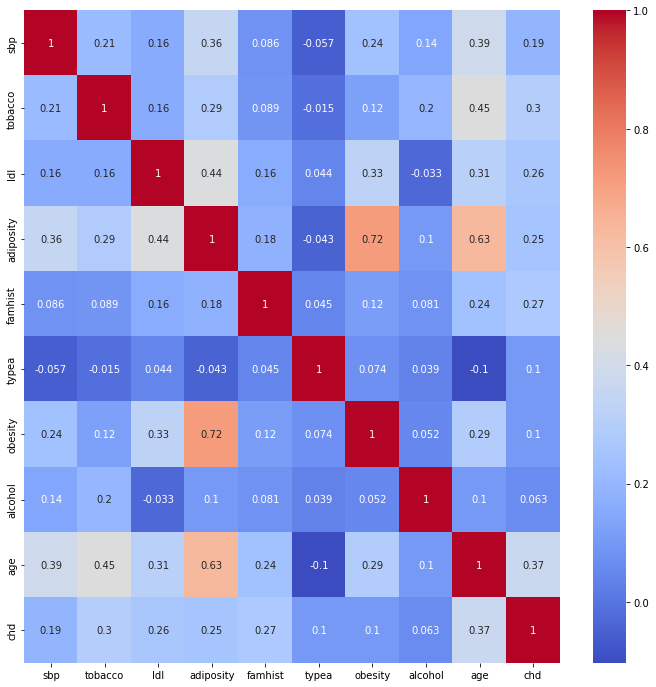

In [12]:
# plot a heatmap of all numeric data with annotation
corr = df.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,cmap='coolwarm')

---

There appear to be strong correlations between Age, Obesity, and Adiposity (fatty tissue in the body).  Not as high but decent correlations between tobacco use and Age, as well as Adiposity and LDL (cholesterol).

---


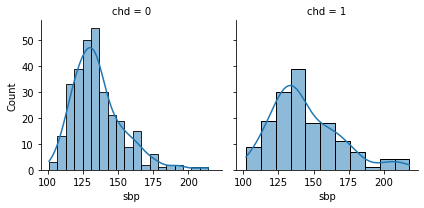

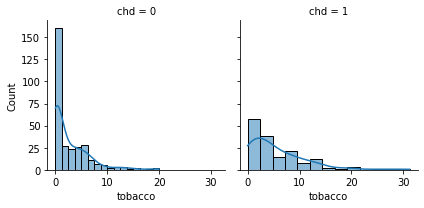

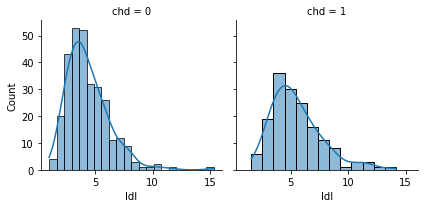

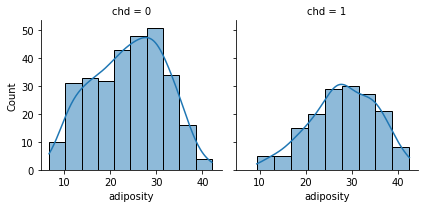

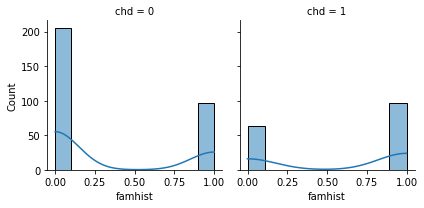

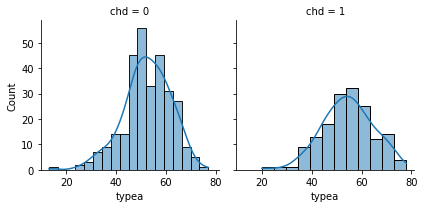

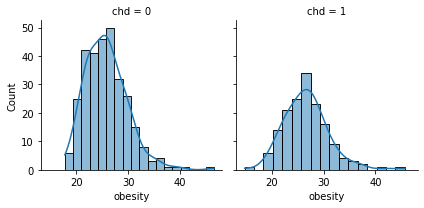

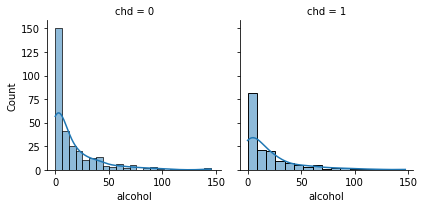

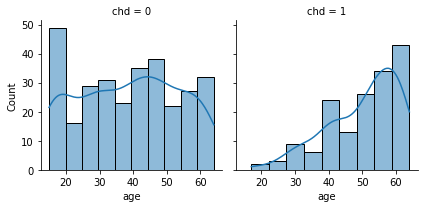

In [14]:
# I found a visualization called FacetGrid that allows me to compare
# a one feature against the others in a meaningful way

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="sbp", kde=True)
  
fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="tobacco", kde=True)

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="ldl", kde=True)
  
fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="adiposity", kde=True)

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="famhist", kde=True)
  
fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="typea", kde=True)

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="obesity", kde=True)
  
fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="alcohol", kde=True)

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="age", kde=True)
  

---

The chart above is a histogram showing the diagnosis of Coronary Heart Disease (CHD 0 is negative, CHD 1 is positive) against each feature in the dataframe
which allows me to directly compare each feature.

---

In [15]:
# (a) Cluster the data using most or all features and analyze those clusters to explain how the clusters are different. 
# (no train test split required)
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
scaled_df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
scaled_df


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,0.478412,-0.295503,1.185854,-0.418470,-0.176786,3.277738,0.629336,1.373863
1,0.277089,-0.790237,-0.159680,0.412140,-0.843274,0.193344,0.671373,-0.612745,1.383115,1.373863
2,-0.992806,-0.774980,-0.609245,0.884332,1.185854,-0.112563,0.735519,-0.541183,0.218184,-0.727875
3,1.546985,0.842264,0.807126,1.624141,1.185854,-0.214532,1.412621,0.295062,1.040488,1.373863
4,-0.211332,2.171805,-0.599577,0.305351,1.185854,0.703189,-0.012856,1.647775,0.423760,1.373863
...,...,...,...,...,...,...,...,...,...,...
457,3.696039,-0.705234,0.599263,0.812281,-0.843274,1.111065,0.571590,-0.696983,1.040488,-0.727875
458,2.133091,0.123004,-0.159680,0.861173,-0.843274,-0.112563,0.609602,0.068519,0.629336,1.373863
459,-1.481228,-0.138545,-1.522877,-1.309364,-0.843274,-1.336191,-1.414575,0.392385,0.834912,-0.727875
460,-0.992806,0.384553,3.320823,0.692625,-0.843274,1.111065,0.310252,0.283203,-0.192969,-0.727875


In [16]:
def plot_k_values(data, ks):
  """plot the silhouette score and inertia 
  of a KMeans model for various k values"""

  sils = []
  inertias = []

  for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sils.append(silhouette_score(data, km.labels_))
    inertias.append(km.inertia_)
      
    # plot inertia and silhouette score
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.set_xlabel('number of clusters')
  ax1.set_ylabel('Inertia', color = 'blue')
  ax1.plot(ks, inertias, color = 'blue',label='inertia',marker ='o')

  ax2 = ax1.twinx()
  
  ax2.set_ylabel('Silhouette Score', color = 'red')
  ax2.plot(ks, sils, color = 'red',label='silhouette score',marker='+')
  ax1.legend(loc=0)  
  ax2.legend(loc='upper left')
  plt.grid()
  plt.show()

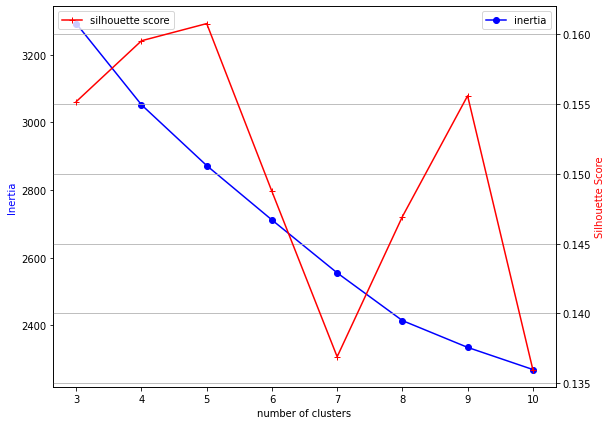

In [17]:
plot_k_values(scaled_df,range(3,11))

In [18]:
# Fit kmeans model with 2 clusters and display the silhouette score
kmeans = KMeans(n_clusters = 4)
kmeans.fit(scaled_df)
silhouette_score(scaled_df, kmeans.labels_)

0.16037866496098466

In [19]:
df["cluster"]=kmeans.labels_

In [20]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).median()
cluster_groups

,cluster,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,0,128.0,0.12,3.31,17.21,0.0,55.0,22.59,2.62,27.0,0.0
1,1,140.0,4.20,5.80,30.23,1.0,54.0,27.29,6.04,55.0,1.0
2,2,142.0,5.99,3.56,27.68,1.0,54.0,26.08,66.27,48.0,0.0
3,3,136.0,2.55,4.89,29.63,0.0,52.0,27.62,8.33,48.0,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

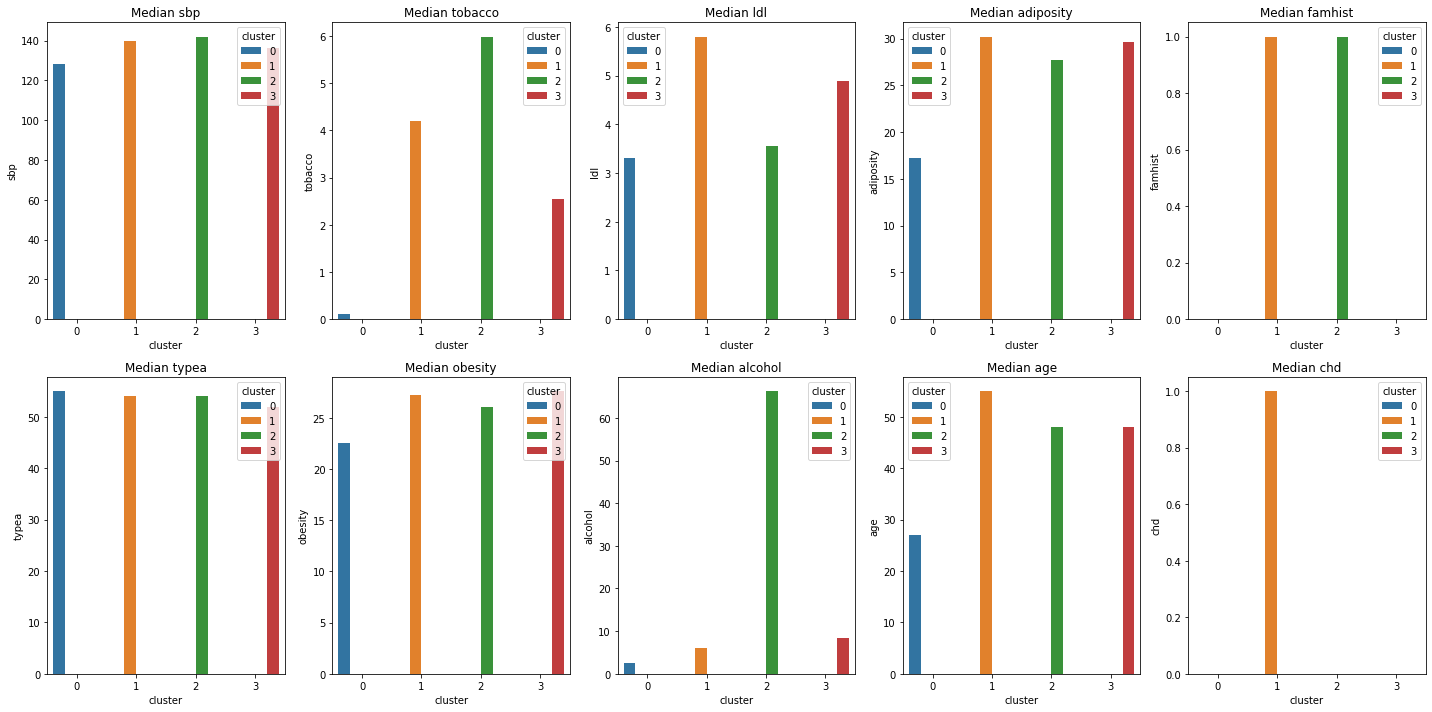

In [21]:
# Visualize means 
fig, axes = plt.subplots(2,5, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  #axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  sns.barplot(cluster_groups['cluster'], cluster_groups[col], hue=cluster_groups['cluster'], ax=axes[i])
  #sns.scatterplot(data=df, x=col, y='price', hue='cluster', ax=axes[i])
  axes[i].set_title(f'Median {col}')
plt.tight_layout()